In [1]:
import os
import json
import lerobot
import numpy as np
import pinocchio as pin
from pathlib import Path
from pprint import pprint
from huggingface_hub import HfApi
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/home/woxue/miniconda3/envs/robocoin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 设置待处理数据集
repo_id = '/media/woxue/garbase/eai_datasets/lerobot/unitree_G1_BAAI_v2/unitree_g1_plate_storage_doll'

In [4]:
# 本体参数：用于正运动学计算末端工作空间

# ================================
# 参数配置
# ================================
URDF_PATH = "../../assets/g1/g1_body29_hand14.urdf"
EE_LEFT_LINK = "left_hand_palm_joint"
EE_RIGHT_LINK = "right_hand_palm_joint"
ARM_JOINT_NAMES = [
    "left_shoulder_pitch_joint", "left_shoulder_roll_joint", "left_shoulder_yaw_joint",
    "left_elbow_joint", "left_wrist_roll_joint", "left_wrist_pitch_joint", "left_wrist_yaw_joint",
    "right_shoulder_pitch_joint", "right_shoulder_roll_joint", "right_shoulder_yaw_joint",
    "right_elbow_joint", "right_wrist_roll_joint", "right_wrist_pitch_joint", "right_wrist_yaw_joint"
]

# 映射名字到索引（用于从任意 qpos 提取对应关节）
name_to_index = {name: idx for idx, name in enumerate(ARM_JOINT_NAMES)}

# 加载模型
model = pin.buildModelFromUrdf(URDF_PATH)
data = model.createData()

# 获取末端执行器 ID
try:
    ee_left_id = model.getFrameId(EE_LEFT_LINK)
    ee_right_id = model.getFrameId(EE_RIGHT_LINK)
except Exception as e:
    raise ValueError(f"Link not found in URDF: {e}")


In [4]:
# 统计工具：计算四元数位姿序列的统计信息

def get_stats_quat(quaternions):
    """
    计算四元数序列的统计信息
    
    参数:
        quaternions: numpy array, shape (N, 4), 格式为 [w, x, y, z]
    
    返回:
        包含四元数统计信息的字典
    """
    import numpy as np
    from scipy.spatial.transform import Rotation as R
    
    quaternions = np.array(quaternions)
    N = quaternions.shape[0]
    
    if N == 0:
        return {
            "mean_quat": [1.0, 0.0, 0.0, 0.0],
            "angular_variance": 0.0,
            "angular_mean_deviation": 0.0,
            "min_roll": 0.0, "max_roll": 0.0,
            "min_pitch": 0.0, "max_pitch": 0.0,
            "min_yaw": 0.0, "max_yaw": 0.0,
            "roll_mean": 0.0, "roll_std": 0.0,
            "pitch_mean": 0.0, "pitch_std": 0.0,
            "yaw_mean": 0.0, "yaw_std": 0.0
        }
    
    # 确保四元数是单位四元数
    norms = np.linalg.norm(quaternions, axis=1, keepdims=True)
    quaternions_normalized = quaternions / norms
    
    # === 1. 计算平均四元数 ===
    def mean_quaternion(quats):
        """使用特征向量方法计算平均四元数"""
        # 处理q和-q的符号歧义
        quats = quats.copy()
        q0 = quats[0]
        for i in range(1, len(quats)):
            if np.dot(quats[i], q0) < 0:
                quats[i] = -quats[i]
        
        # 构建协方差矩阵
        Q = quats.T @ quats
        # 最大特征值对应的特征向量
        eigenvals, eigenvecs = np.linalg.eigh(Q)
        mean_q = eigenvecs[:, np.argmax(eigenvals)]
        return mean_q / np.linalg.norm(mean_q)
    
    mean_quat = mean_quaternion(quaternions_normalized)
    
    # === 2. 计算角度方差和平均偏差 ===
    def quaternion_angular_distance(q1, q2):
        """计算两个四元数之间的最小旋转角度（弧度）"""
        dot_product = np.abs(np.dot(q1, q2))  # 处理q和-q
        dot_product = np.clip(dot_product, -1.0, 1.0)
        return 2 * np.arccos(dot_product)
    
    angles = []
    for q in quaternions_normalized:
        angle = quaternion_angular_distance(q, mean_quat)
        angles.append(angle)
    angles = np.array(angles)
    
    angular_variance = np.var(angles)
    angular_mean_deviation = np.mean(angles)
    
    # === 3. 转换为欧拉角进行范围统计 ===
    # scipy使用[x, y, z, w]格式，而我们的数据是[w, x, y, z]
    scipy_quats = np.column_stack([quaternions_normalized[:, 1],  # x
                                   quaternions_normalized[:, 2],  # y  
                                   quaternions_normalized[:, 3],  # z
                                   quaternions_normalized[:, 0]]) # w
    
    try:
        rotations = R.from_quat(scipy_quats)
        euler_angles = rotations.as_euler('xyz', degrees=False)  # roll, pitch, yaw
        
        roll = euler_angles[:, 0]
        pitch = euler_angles[:, 1]
        yaw = euler_angles[:, 2]
        
        # 处理角度环绕问题（可选，这里简单处理）
        def unwrap_angles(angles):
            """简单处理角度环绕"""
            return np.unwrap(angles)
        
        roll_unwrapped = unwrap_angles(roll)
        pitch_unwrapped = unwrap_angles(pitch)
        yaw_unwrapped = unwrap_angles(yaw)
        
        # 统计信息
        stats = {
            "mean_quat": mean_quat.tolist(),
            "angular_variance": float(angular_variance),
            "angular_mean_deviation": float(angular_mean_deviation),
            
            "min" : [float(np.min(roll)), float(np.min(pitch)), float(np.min(yaw))], # roll, pitch, yaw
            "max" : [float(np.max(roll)), float(np.max(pitch)), float(np.max(yaw))], # roll, pitch, yaw
            "mean": [float(np.mean(roll_unwrapped)), float(np.mean(pitch_unwrapped)), float(np.mean(yaw_unwrapped))], # roll, pitch, yaw
            "std": [float(np.std(roll_unwrapped)), float(np.std(pitch_unwrapped)), float(np.std(yaw_unwrapped))] # roll, pitch, yaw
        }
        
    except Exception as e:
        # 如果欧拉角转换失败，返回基本统计信息
        print(f"Warning: Euler angle conversion failed: {e}")
        stats = {
            "mean_quat": mean_quat.tolist(),
            "angular_variance": float(angular_variance),
            "angular_mean_deviation": float(angular_mean_deviation),
            "min" : [0.0, 0.0, 0.0], # roll, pitch, yaw
            "max" : [0.0, 0.0, 0.0], # roll, pitch, yaw
            "mean": [0.0, 0.0, 0.0], # roll, pitch, yaw
            "std": [0.0, 0.0, 0.0] # roll, pitch, yaw
        }
    
    return stats


In [ ]:
# 统计工具：计算末端轨迹、末端朝向、工作空间、速度、加速度的统计信息

def compute_hand_workspace_with_velocity_acceleration_from_qpos(
    dataset, 
    model,
    ranges,
    dt=1/30,
    return_traj=False,
):
    """
    输入：
        - dataset: iterable，每项有 ['observation']['state'] 表示 qpos（仅手臂14维）
        - model: Pinocchio 模型
        - ee_left_name / ee_right_name: 末端链接名
        - dt: 时间步长（秒），默认 0.02 对应 50Hz
    
    输出：
        包含左右手位置、姿态、速度、加速度的轨迹与统计信息
    """

    nq = model.nq
    nv = model.nv
    # print(f"Model nq = {nq}, nv = {nv}")

    # 初始化 full state
    q_full = np.zeros(nq)
    qv_full = np.zeros(nv)

    data = model.createData()

    # 存储所有时间步的数据（注意：速度/加速度比位置少一或两帧）
    left_positions = []
    left_quaternions = []
    left_velocities = []  # 6D spatial velocity at each valid time step
    left_accelerations = []

    right_positions = []
    right_quaternions = []
    right_velocities = []
    right_accelerations = []
    
    left_linear_speeds = []
    left_angular_speeds = []
    left_linear_accs = []
    left_angular_accs = []
    
    right_linear_speeds = []
    right_angular_speeds = []
    right_linear_accs = []
    right_angular_accs = []
    

    # N = len(dataset)
    # N = 200
    N = ranges[1] - ranges[0]

    # 缓存 qpos 序列用于差分
    # qpos_seq = [np.array(dataset[i]['observation.state']) for i in range(N)]
    qpos_seq = []
    for t in tqdm(range(ranges[0], ranges[1]), desc="Cache qpos"):
        qpos_seq.append(np.array(dataset[t]['observation.state']))
        # qpos_seq.append(np.array(dataset.get_item_woimg(t)['observation.state'])) # 可以在lerobot_dataset中实现一个忽略图片的get_item方法加速读取
    # 预估 qvel：使用前向差分（最后一个点用后向差分对齐）
    qvel_estimated = []
    # print('len(qpos_seq)', len(qpos_seq))
    for t in tqdm(range(N), desc="Processing velocity&acceleration"):
        # print('t=', t)
        if t == N - 1:
            # 最后一个时刻：用后向差分
            dq = qpos_seq[t] - qpos_seq[t-1]
        else:
            dq = qpos_seq[t+1] - qpos_seq[t]
        qvel_t = dq / dt
        qvel_estimated.append(qvel_t)
    
    prev_left_vel_sp = None
    prev_right_vel_sp = None

    for t in tqdm(range(N), desc="Processing trajectory"):
        qpos = qpos_seq[t]
        qvel = qvel_estimated[t]  # 已估计的关节速度
        # print('debug qpos.shape', qpos.shape)
        # print('debug qvel.shape', qvel.shape)
        # 设置全状态
        q_full[16:23] = qpos[:7]      # 左臂
        q_full[30:37] = qpos[7:14]   # 右臂
        qv_full[16:23] = qvel[:7]
        qv_full[30:37] = qvel[7:14]
        # 其他关节设为0或保持不变...

        # 正运动学（位置 & 姿态）
        pin.forwardKinematics(model, data, q_full)
        pin.updateFramePlacements(model, data)

        # --- 位置与姿态 ---
        T_left = data.oMf[ee_left_id]
        pos_left = T_left.translation.copy()
        quat_left = pin.Quaternion(T_left.rotation)
        quat_left.normalize()
        wxyz_left = [quat_left.w, quat_left.x, quat_left.y, quat_left.z]

        T_right = data.oMf[ee_right_id]
        pos_right = T_right.translation.copy()
        quat_right = pin.Quaternion(T_right.rotation)
        quat_right.normalize()
        wxyz_right = [quat_right.w, quat_right.x, quat_right.y, quat_right.z]

        # --- 速度：使用 estimated qvel 计算空间速度 ---
        pin.computeForwardKinematicsDerivatives(model, data, q_full, qv_full, np.zeros(nv))
        v_left_sp = pin.getFrameVelocity(model, data, ee_left_id).vector  # 6D twist
        v_right_sp = pin.getFrameVelocity(model, data, ee_right_id).vector

        # --- 加速度：数值微分 ---
        acc_left_sp = np.zeros(6)
        acc_right_sp = np.zeros(6)

        if prev_left_vel_sp is not None:
            acc_left_sp = (v_left_sp - prev_left_vel_sp) / dt
            acc_right_sp = (v_right_sp - prev_right_vel_sp) / dt
        # 第一帧加速度设为0
        else:
            # 可选：跳过第一帧记录（这里保留，补零）
            pass
        
        # --- 分别计算线速度和角速度的模（标量）---
        # Left hand
        linear_vel_left = v_left_sp[:3]
        angular_vel_left = v_left_sp[3:]
        left_linear_speeds.append(np.linalg.norm(linear_vel_left))
        left_angular_speeds.append(np.linalg.norm(angular_vel_left))

        linear_acc_left = acc_left_sp[:3]
        angular_acc_left = acc_left_sp[3:]
        left_linear_accs.append(np.linalg.norm(linear_acc_left))
        left_angular_accs.append(np.linalg.norm(angular_acc_left))

        # Right hand
        linear_vel_right = v_right_sp[:3]
        angular_vel_right = v_right_sp[3:]
        right_linear_speeds.append(np.linalg.norm(linear_vel_right))
        right_angular_speeds.append(np.linalg.norm(angular_vel_right))

        linear_acc_right = acc_right_sp[:3]
        angular_acc_right = acc_right_sp[3:]
        right_linear_accs.append(np.linalg.norm(linear_acc_right))
        right_angular_accs.append(np.linalg.norm(angular_acc_right))

        # 存储
        left_positions.append(pos_left)
        left_quaternions.append(wxyz_left)
        left_velocities.append(v_left_sp.copy())
        left_accelerations.append(acc_left_sp)

        right_positions.append(pos_right)
        right_quaternions.append(wxyz_right)
        right_velocities.append(v_right_sp.copy())
        right_accelerations.append(acc_right_sp)

        # 更新上一时刻速度
        prev_left_vel_sp = v_left_sp.copy()
        prev_right_vel_sp = v_right_sp.copy()

    # 转 NumPy 数组
    left_positions = np.array(left_positions)
    left_quaternions = np.array(left_quaternions)
    left_velocities = np.array(left_velocities)
    left_accelerations = np.array(left_accelerations)

    right_positions = np.array(right_positions)
    right_quaternions = np.array(right_quaternions)
    right_velocities = np.array(right_velocities)
    right_accelerations = np.array(right_accelerations)

    # 统计函数
    def get_stats(arr, axis=0):
        return {
            "min": np.min(arr, axis=axis).tolist(),
            "max": np.max(arr, axis=axis).tolist(),
            "mean": np.mean(arr, axis=axis).tolist(),
            "std": np.std(arr, axis=axis).tolist()
        }
        
    results =  {
        # 统计信息
        "left_stat": {
            "position": get_stats(left_positions),
            "orientation": get_stats_quat(left_quaternions),  # 使用四元数统计
            # "velocity": get_stats(left_velocities),
            # "acceleration": get_stats(left_accelerations),
            "linear_speed": get_stats(left_linear_speeds),
            "angular_speed": get_stats(left_angular_speeds),
            "linear_acc": get_stats(left_linear_accs),
            "angular_acc": get_stats(left_angular_accs)
        },
        "right_stat": {
            "position": get_stats(right_positions),
            "orientation": get_stats_quat(right_quaternions),  # 使用四元数统计
            "linear_speed": get_stats(right_linear_speeds),
            "angular_speed": get_stats(right_angular_speeds),
            "linear_acc": get_stats(right_linear_accs),
            "angular_acc": get_stats(right_angular_accs)
        },
        "duration": N * dt
    }
    if return_traj:
        results["left_positions"] = left_positions
        results["left_quaternions"] = left_quaternions
        results["right_positions"] = right_positions
        results["right_quaternions"] = right_quaternions
        
    return results

In [6]:
# 统计工具：获取一个episode的subtask列表
def get_subtask_index_range(dataset):
    subtask_segments = []
    
    current_subtask = None
    current_subtask_idx = None
    start_frame = None
    current_episode = None

    num_items = len(dataset)
    prev_frame = None

    for i in range(num_items):
        item = dataset.get_item_woimg(i)
        
        episode_idx = item['episode_index'].item()
        frame_idx = item['frame_index'].item()
        subtask_desc = item['subtasks'][0]
        subtask_idx = item['subtask_indices'][0].item()
        
        # 判断是否是有效 subtask
        is_valid = (subtask_desc != "null")
        
        # 如果当前是有效 subtask
        if is_valid:
            # 如果是新 subtask（不同描述 或 不同 episode）
            if (current_subtask is None 
                or current_subtask != subtask_desc 
                or current_episode != episode_idx):
                
                # 先结束上一个 subtask（如果存在）
                if current_subtask is not None:
                    subtask_segments.append({
                        'ranges': {'start': start_frame, 'end': prev_frame},
                        'subtask_indice': current_subtask_idx,
                        'subtask': current_subtask
                    })
                
                # 开始新的 subtask
                current_subtask = subtask_desc
                current_subtask_idx = subtask_idx
                current_episode = episode_idx
                start_frame = frame_idx
        else:
            # 当前是 null：结束当前 subtask（如果存在）
            if current_subtask is not None:
                subtask_segments.append({
                    'ranges': {'start': start_frame, 'end': prev_frame},
                    'subtask_indice': current_subtask_idx,
                    'subtask': current_subtask
                })
                current_subtask = None
                current_subtask_idx = None
                start_frame = None
        
        prev_frame = frame_idx

    # 处理最后一个未结束的 subtask
    if current_subtask is not None:
        subtask_segments.append({
            'ranges': {'start': start_frame, 'end': prev_frame},
            'subtask_indice': current_subtask_idx,
            'subtask': current_subtask
        })
    
    return subtask_segments


In [ ]:
# 批处理：生成每个episode的xray数据

# repo_id = '/media/woxue/garbase/eai_datasets/lerobot/unitree_G1_BAAI_v2/unitree_g1_plate_storage_doll'
dataset = LeRobotDataset(repo_id, episodes=[0])
num_episodes = len(dataset.meta.episodes)
out_dir = os.path.join(repo_id, 'xray')
os.makedirs(out_dir, exist_ok=True)
for i in range(num_episodes):
    dataset = LeRobotDataset(repo_id, episodes=[i])
    subtask_segments = get_subtask_index_range(dataset)
    for subtask in subtask_segments:
        if subtask['ranges']['end'] - subtask['ranges']['start'] < 5: # 跳过过于短的片段
            subtask['stats'] = {}
        else:
            subtask_stats = compute_hand_workspace_with_velocity_acceleration_from_qpos(
                dataset, 
                model,
                ranges=[subtask['ranges']['start'], subtask['ranges']['end']],
                dt=1/30
            )
            subtask['stats'] = subtask_stats
    with open(os.path.join(out_dir, 'episode_' + f"{i:06d}" + '.json'), 'w', encoding='utf-8') as f:
        json.dump(subtask_segments, f, ensure_ascii=False, indent=4)

In [ ]:
# 可视化工具：末端执行器运动位姿分布球形图

def visualize_hand_orientation_sphere_from_result(result):
    """
    根据 compute_hand_workspace 的输出 result，
    可视化左右手末端执行器朝向（z轴）在单位球上的分布。

    参数:
        result (dict): 来自 compute_hand_workspace 的返回值，必须包含:
                       - 'left_quaternions': (N, 4) [w,x,y,z]
                       - 'right_quaternions': (N, 4) [w,x,y,z]
    """
    # 提取四元数
    left_quats = result["left_quaternions"]  # shape: (N, 4), format: [w, x, y, z]
    right_quats = result["right_quaternions"]

    # 将四元数转为旋转矩阵，并提取 z 轴方向（即末端前进方向）
    def quats_to_z_directions(quats):
        z_dirs = []
        for q in quats:
            w, x, y, z = q
            # 构造 scipy 的 Quaternion（格式也是 [w,x,y,z]）
            rot = R.from_quat([x, y, z, w])  # 注意：scipy 接受 [x,y,z,w]
            R_mat = rot.as_matrix()
            z_dir_body = np.array([0, 0, 1])  # 局部坐标系 z 向量
            z_dir_world = R_mat @ z_dir_body   # 变换到世界坐标系
            z_dir_world /= np.linalg.norm(z_dir_world)
            z_dirs.append(z_dir_world)
        return np.array(z_dirs)

    from scipy.spatial.transform import Rotation as R

    left_dirs = quats_to_z_directions(left_quats)
    right_dirs = quats_to_z_directions(right_quats)

    # ========================
    # 绘图：单位球 + 方向点云
    # ========================

    fig = plt.figure(figsize=(14, 7))

    # ---- 左手 ----
    ax1 = fig.add_subplot(121, projection='3d')
    _plot_unit_sphere_with_dirs(ax1, left_dirs, title="Left Hand EE Orientation (Z-axis)")

    # ---- 右手 ----
    ax2 = fig.add_subplot(122, projection='3d')
    _plot_unit_sphere_with_dirs(ax2, right_dirs, title="Right Hand EE Orientation (Z-axis)")

    plt.tight_layout()
    plt.show()


def _plot_unit_sphere_with_dirs(ax, directions, title="Orientation Distribution"):
    """
    辅助函数：绘制单位球与方向点
    """
    # 单位球表面
    u = np.linspace(0, 2 * np.pi, 60)
    v = np.linspace(0, np.pi, 30)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(x, y, z, color='lightgray', alpha=0.15, linewidth=1, edgecolor='gray')

    # 坐标轴箭头
    arrow_length = 1.1
    ax.quiver(0, 0, 0, 1, 0, 0, color='r', linewidth=1.5, arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, 0, 1, 0, color='g', linewidth=1.5, arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, 0, 0, 1, color='b', linewidth=1.5, arrow_length_ratio=0.1)

    # 使用方位角着色（HSV 色彩循环）
    phis = np.arctan2(directions[:, 1], directions[:, 0])
    sc = ax.scatter(directions[:, 0], directions[:, 1], directions[:, 2],
                    c=phis, cmap='hsv', s=10, alpha=0.8)

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_zlim(-1.1, 1.1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)

    # 添加颜色条（代表绕竖直轴的朝向）
    plt.colorbar(sc, ax=ax, shrink=0.5, aspect=20, label='Azimuth (φ)')

In [11]:
# 可视化工具：末端执行器空间运动轨迹

def plot_workspace(result):
    left_positions = result["left_positions"]
    right_positions = result["right_positions"]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(left_positions[:,0], left_positions[:,1], left_positions[:,2], c='r', label='Left Hand', s=1)
    ax.scatter(right_positions[:,0], right_positions[:,1], right_positions[:,2], c='b', label='Right Hand', s=1)
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.legend()
    plt.title("Hand Workspace from Trajectory")
    plt.show()


Model nq = 43, nv = 43


Cache qpos:   0%|          | 0/499 [00:00<?, ?it/s]/tmp/ipykernel_2521379/3443528118.py:61: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  qpos_seq.append(np.array(dataset.get_item_woimg(t)['observation.state']))
Processing trajectory: 100%|██████████| 499/499 [00:00<00:00, 6907.50it/s]


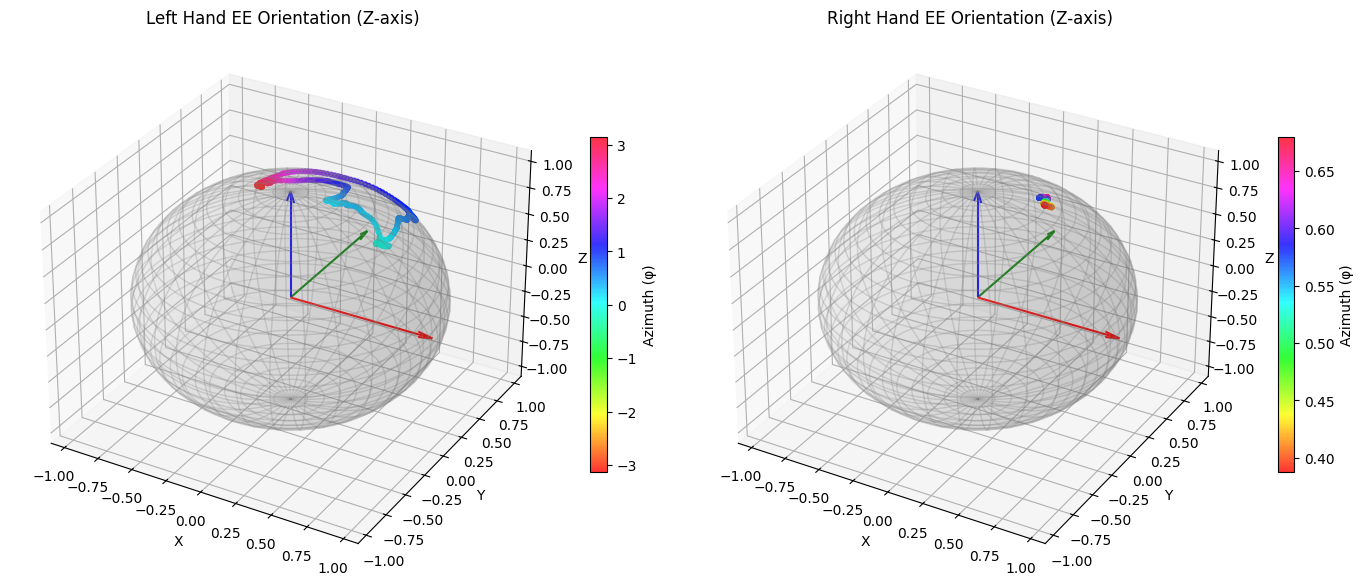

In [9]:
# 可视化：末端执行器运动位姿分布球形图

dataset = LeRobotDataset(repo_id, episodes=[0])
result_vis = compute_hand_workspace_with_velocity_acceleration_from_qpos(
    dataset, 
    model, 
    ranges=[1,500],
    dt=1/30,
    return_traj=True,
)
visualize_hand_orientation_sphere_from_result(result_vis)

Model nq = 43, nv = 43


Cache qpos:   0%|          | 0/499 [00:00<?, ?it/s]/tmp/ipykernel_2521379/3443528118.py:61: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  qpos_seq.append(np.array(dataset.get_item_woimg(t)['observation.state']))
Processing trajectory: 100%|██████████| 499/499 [00:00<00:00, 6755.57it/s]


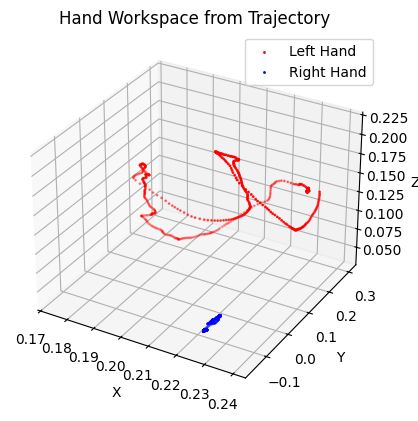

In [12]:
# 可视化：末端执行器空间运动轨迹

dataset = LeRobotDataset(repo_id, episodes=[0])
result_vis = compute_hand_workspace_with_velocity_acceleration_from_qpos(
    dataset, 
    model, 
    ranges=[1,500],
    dt=1/30,
    return_traj=True,
)
plot_workspace(result_vis)